In [ ]:
import pandas as pd, numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import roc_curve, auc,roc_auc_score


Initial shape: (2040, 57)
X                    0.000000
Y                    0.000000
INDEX_               0.049020
ACCNUM               0.049020
YEAR                 0.049020
DATE                 0.049020
TIME                 0.049020
HOUR                 0.049020
STREET1              0.049020
STREET2             10.882353
OFFSET              99.901961
ROAD_CLASS           3.333333
DISTRICT             0.049020
WARDNUM              0.049020
DIVISION             0.049020
LATITUDE             0.049020
LONGITUDE            0.049020
LOCCOORD             0.931373
ACCLOC              54.852941
TRAFFCTL             0.294118
VISIBILITY           0.049020
LIGHT                0.049020
RDSFCOND             0.049020
ACCLASS              0.049020
IMPACTYPE            0.049020
INVTYPE              0.098039
INVAGE               0.049020
INJURY               8.186275
FATAL_NO           100.000000
INITDIR             38.039216
VEHTYPE              1.274510
MANOEUVER           46.323529
DRIVACT       

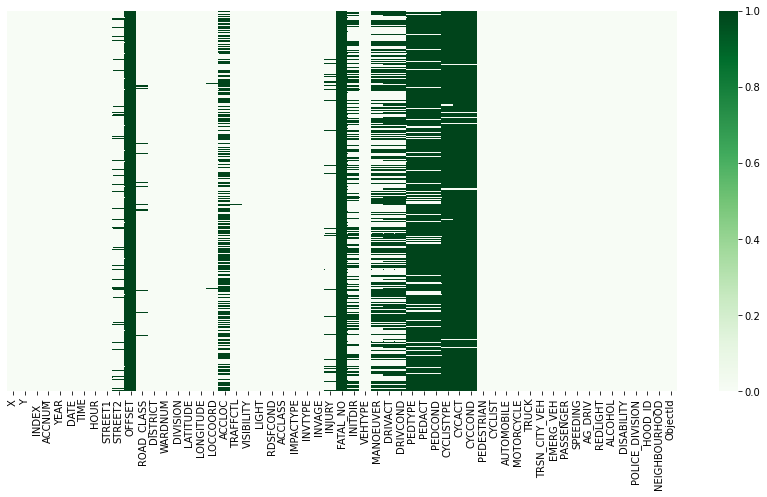

In [ ]:

data = pd.read_csv('KSI.csv')
print("Initial shape:", data.shape)

# There are several columns consist of "Yes" and "<Null>" (where Null means No). 
# For these binary column, replace  "<Null>" with"No"
binary_cols = ['CYCLIST','AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH','SPEEDING','REDLIGHT','ALCOHOL','DISABILITY','PASSENGER','AG_DRIV','PEDESTRIAN']
data[binary_cols]=data[binary_cols].replace({'<Null>':'No', 'Yes':'Yes'})

# Replace other '<Null>' with nan, printing percentage of missing values for each feature
data.replace('<Null>', np.nan, inplace=True)
data.replace(' ',np.nan,inplace=True)
print(data.isna().sum()/len(data)*100)

#The following heatmap shows the features having maximum missing values
fig, ax = plt.subplots(figsize=(15,7))
#heatmap to visualize features with most missing values
sns.heatmap(data.isnull(), yticklabels=False,cmap='Greens')
#shape
print(data.shape)

# Dropping columns where missing values were greater than 80%
drop_column = ['OFFSET','FATAL_NO','PEDTYPE','PEDACT','PEDCOND','CYCLISTYPE','CYCACT','CYCCOND']
data.drop(drop_column, axis=1, inplace=True)
#Drop irrelevant columns which are unique identifier
data.drop(['ObjectId','INDEX_'], axis=1, inplace=True)

print(data.shape)
print(data.isna().sum()/len(data)*100)

print(data.info())


#Changing the property damage and non-fatal columns to Non-Fatal¶
data['ACCLASS'] = np.where(data['ACCLASS'] == 'Property Damage Only', 'Non-Fatal', data['ACCLASS'])
data['ACCLASS'] = np.where(data['ACCLASS'] == 'Non-Fatal Injury', 'Non-Fatal', data['ACCLASS'])

data['ACCLASS'].unique()

## Verifying columns with object data type
print(data.select_dtypes(["object"]).columns)


# Neighbourhood is identical with Hood ID
#data.rename(columns={'Hood ID': 'Neighbourhood'}, inplace=True) # Neighbourhood is identical with Hood ID

# extract features: weekday,day, month 
data['DATE'] = pd.to_datetime(data['DATE'])
data['WEEKDAY'] =data['DATE'].dt.dayofweek
data['DAY'] = pd.to_datetime(data['DATE']).dt.day
data['MONTH'] = data['DATE'].dt.month

#Drop Date
data.drop(['DATE'], axis=1, inplace=True)


In [ ]:
data.describe()

,X,Y,ACCNUM,YEAR,TIME,HOUR,LATITUDE,LONGITUDE,HOOD_ID,WEEKDAY,DAY,MONTH
count,2.040000e+03,2.040000e+03,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,-8.838941e+06,5.420490e+06,929970.850907,2006.272683,1343.158901,13.157921,43.708736,-79.401679,71.571359,3.002943,15.305051,5.968612
std,1.163437e+04,8.499490e+03,26017.945919,0.445448,656.118275,6.554712,0.055157,0.104402,41.813029,2.008322,8.708006,3.396008
min,-8.864837e+06,5.403940e+06,882024.000000,2006.000000,1.000000,0.000000,43.601245,-79.634190,1.000000,0.000000,1.000000,1.000000
25%,-8.847076e+06,5.413160e+06,909745.000000,2006.000000,850.000000,8.000000,43.661145,-79.474790,38.000000,1.000000,8.000000,3.000000
50%,-8.838933e+06,5.419371e+06,927585.000000,2006.000000,1435.000000,14.000000,43.701545,-79.401490,76.000000,3.000000,15.000000,6.000000
75%,-8.830440e+06,5.427212e+06,950226.000000,2007.000000,1900.000000,19.000000,43.752445,-79.325290,108.000000,5.000000,22.000000,9.000000
max,-8.811660e+06,5.441139e+06,997046.000000,2007.000000,2358.000000,23.000000,43.842745,-79.156490,140.000000,6.000000,31.000000,12.000000


#Exploration

In [ ]:

# Neighbourhood is identical with Hood ID, drop Neighbourhood
# X,Y are longitude and latitudes, dulicate, drop X and Y
data.drop(['NEIGHBOURHOOD','X','Y'], axis=1, inplace=True)

data['STREET1'].value_counts()
data['POLICE_DIVISION'].value_counts() 
# remove other irrelevant columns or columns contain too many missing values
data.drop(['MANOEUVER','DRIVACT','DRIVCOND','INITDIR','STREET1','STREET2','WARDNUM','POLICE_DIVISION','DIVISION'], axis=1, inplace=True)


In [ ]:
data['INJURY'].value_counts()

None       845
Major      654
Minor      181
Minimal    121
Fatal       72
Name: INJURY, dtype: int64

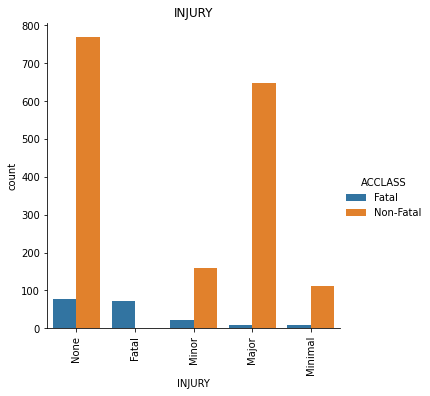

In [ ]:

#Injury
ax=sns.catplot(x='INJURY', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=90)
plt.title("INJURY")

data['INJURY'].value_counts()

# Injury too closely related to fatal/non-fatal, drop
data.drop(['INJURY'], axis=1, inplace=True)

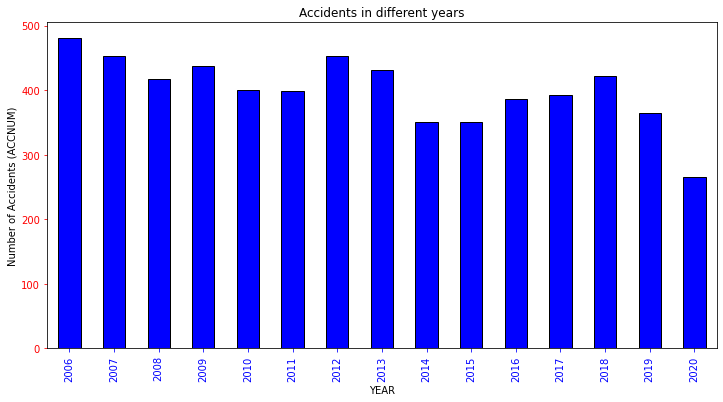

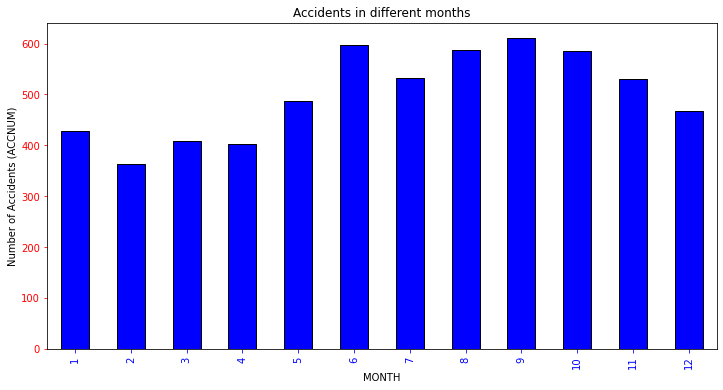

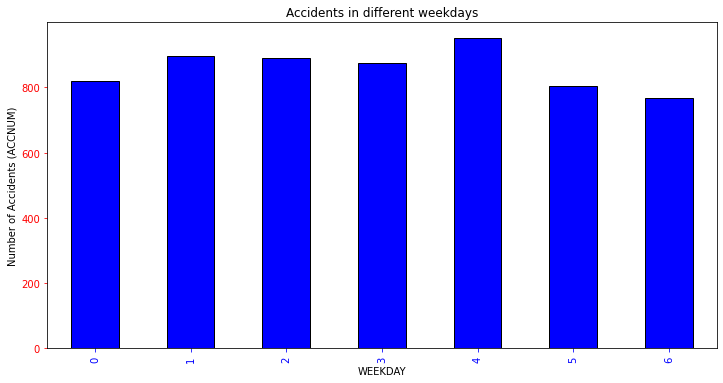

Text(0.5, 1.0, 'Light condition')

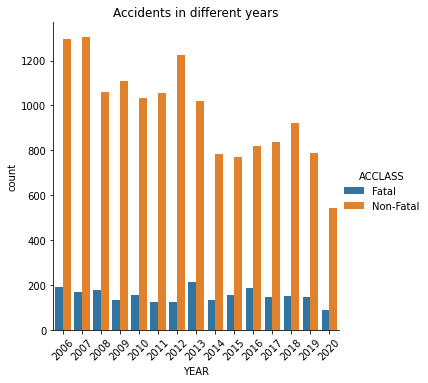

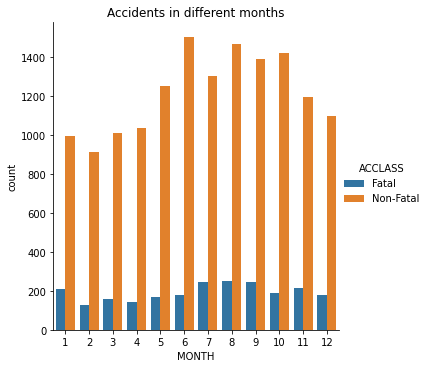

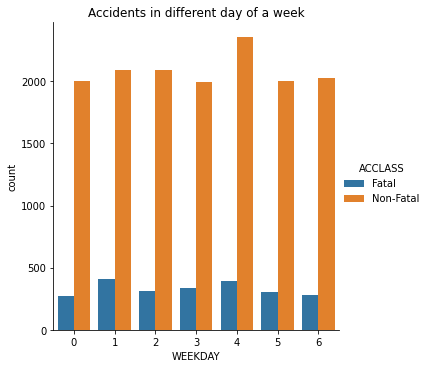

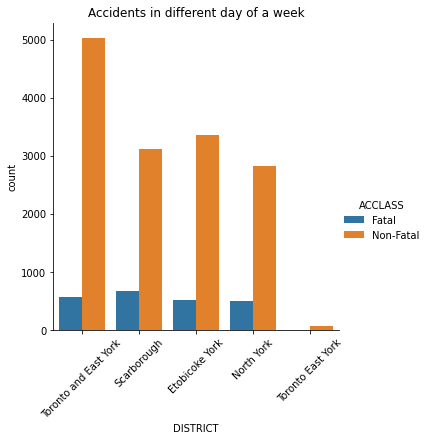

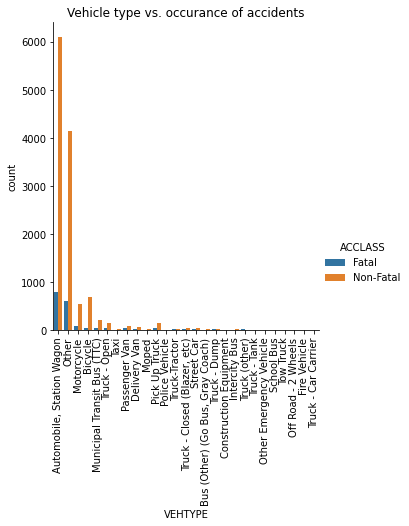

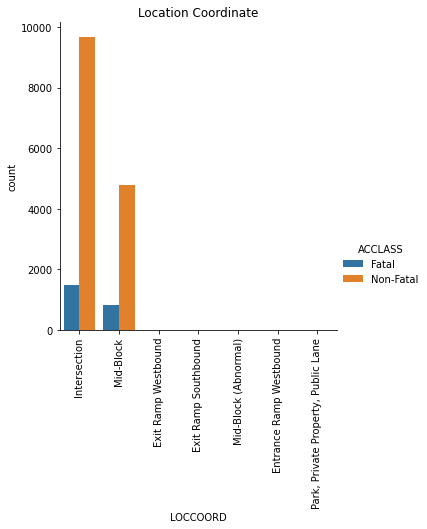

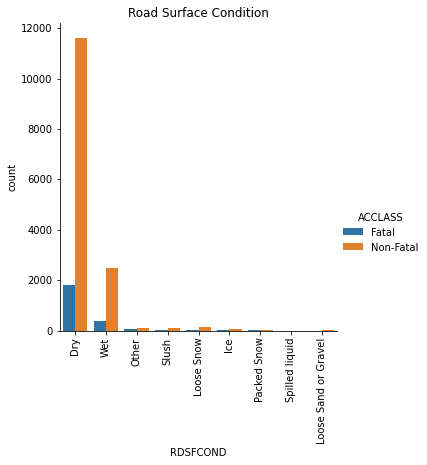

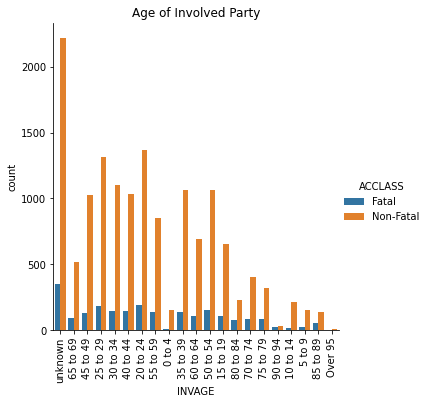

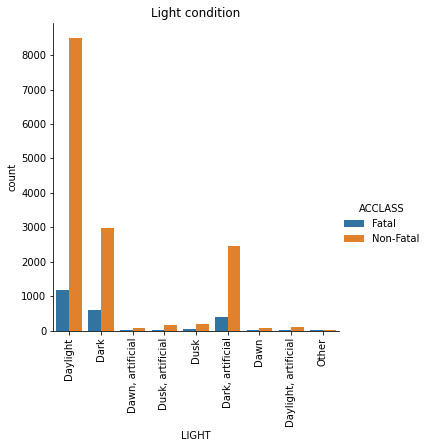

In [ ]:

#Number of Unique accidents by Year
Num_accident = data.groupby('YEAR')['ACCNUM'].nunique()
plt.figure(figsize=(12,6))
plt.title("Accidents in different years")
plt.ylabel('Number of Accidents (ACCNUM)')
ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='red')
my_colors = list('rgbkymc')   #red, green, blue, black, etc.
Num_accident.plot(
    kind='bar', 
    color='blue',
    edgecolor='black'
)
#Num_accident.plot(kind='bar',color= my_colors)
plt.show()

#Number of Unique accidents by Month
Num_accident = data.groupby('MONTH')['ACCNUM'].nunique()
plt.figure(figsize=(12,6))
plt.title("Accidents in different months")
plt.ylabel('Number of Accidents (ACCNUM)')

ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='red')
my_colors = list('rgbkymc')   #red, green, blue, black, etc.
Num_accident.plot(
    kind='bar', 
    color='blue',
    edgecolor='black'
)
#Num_accident.plot(kind='bar',color= my_colors)
plt.show()

#From the data above, accidents happened more from June to October

#Number of Unique accidents by Day
Num_accident = data.groupby('WEEKDAY')['ACCNUM'].nunique()
plt.figure(figsize=(12,6))
plt.title("Accidents in different weekdays")
plt.ylabel('Number of Accidents (ACCNUM)')
ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='red')
my_colors = list('rgbkymc')   #red, green, blue, black, etc.
Num_accident.plot(
    kind='bar', 
    color='blue',
    edgecolor='black'
)
#Num_accident.plot(kind='bar',color= my_colors)
plt.show()

#Check the relation between features and target
#Year
ax=sns.catplot(x='YEAR', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=45)
plt.title("Accidents in different years")


#Month
ax=sns.catplot(x='MONTH', kind='count', data=data,  hue='ACCLASS')
plt.title("Accidents in different months")


#Month
ax=sns.catplot(x='WEEKDAY', kind='count', data=data,  hue='ACCLASS')
plt.title("Accidents in different day of a week")

#Neighborhood
ax=sns.catplot(x='DISTRICT', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=45)
plt.title("Accidents in different day of a week")

#Vehicle type
ax=sns.catplot(x='VEHTYPE', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=90)
plt.title("Vehicle type vs. occurance of accidents")

#LOCCOORD
ax=sns.catplot(x='LOCCOORD', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=90)
plt.title("Location Coordinate")


#RDSFCOND
ax=sns.catplot(x='RDSFCOND', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=90)
plt.title("Road Surface Condition")


#INVAGE
ax=sns.catplot(x='INVAGE', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=90)
plt.title("Age of Involved Party")


#Light
ax=sns.catplot(x='LIGHT', kind='count', data=data,  hue='ACCLASS')
ax.set_xticklabels(rotation=90)
plt.title("Light condition")


In [ ]:
data['ACCLASS']

0            Fatal
1            Fatal
2            Fatal
3            Fatal
4            Fatal
           ...    
16855    Non-Fatal
16856    Non-Fatal
16857    Non-Fatal
16858    Non-Fatal
16859    Non-Fatal
Name: ACCLASS, Length: 16860, dtype: object

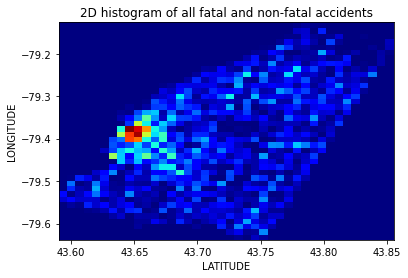

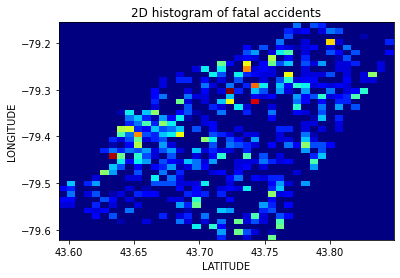

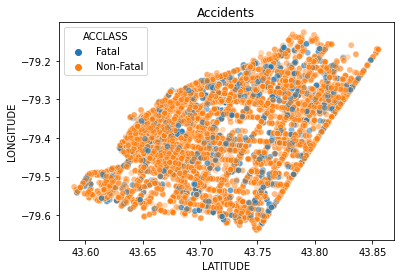

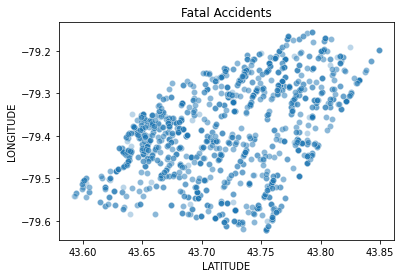

In [ ]:

# Where does accident more likly to occur
#2D histogram
plt.hist2d(data['LATITUDE'], data['LONGITUDE'], bins=(40, 40), cmap=plt.cm.jet)
plt.title("2D histogram of all fatal and non-fatal accidents")
plt.xlabel("LATITUDE")
plt.ylabel("LONGITUDE")
plt.show()

data_Fatal = data[data['ACCLASS'] == 'Fatal']
plt.hist2d(data_Fatal['LATITUDE'], data_Fatal['LONGITUDE'], bins=(40, 40), cmap=plt.cm.jet)
plt.title("2D histogram of fatal accidents")
plt.xlabel("LATITUDE")
plt.ylabel("LONGITUDE")
plt.show()


# scatter plot of all fatal and non-fatal accidents
sns.scatterplot(x='LATITUDE', y='LONGITUDE', data = data, hue = "ACCLASS",alpha=0.3)
plt.title("Accidents")
plt.show()
#scatter plot of fatal accidents
sns.scatterplot(x='LATITUDE', y='LONGITUDE', data = data[data['ACCLASS'] == 'Fatal'],alpha=0.3)
plt.title("Fatal Accidents")
plt.show()


#Data Preprocessing

ACCNUM            0.049020
YEAR              0.049020
TIME              0.049020
HOUR              0.049020
ROAD_CLASS        3.333333
DISTRICT          0.049020
LATITUDE          0.049020
LONGITUDE         0.049020
LOCCOORD          0.931373
ACCLOC           54.852941
TRAFFCTL          0.294118
VISIBILITY        0.049020
LIGHT             0.049020
RDSFCOND          0.049020
ACCLASS           0.049020
IMPACTYPE         0.049020
INVTYPE           0.098039
INVAGE            0.049020
VEHTYPE           1.274510
PEDESTRIAN        0.049020
CYCLIST           0.049020
AUTOMOBILE        0.049020
MOTORCYCLE        0.049020
TRUCK             0.049020
TRSN_CITY_VEH     0.049020
EMERG_VEH         0.049020
PASSENGER         0.049020
SPEEDING          0.049020
AG_DRIV           0.049020
REDLIGHT          0.049020
ALCOHOL           0.049020
DISABILITY        0.049020
HOOD_ID           0.049020
WEEKDAY           0.049020
DAY               0.049020
MONTH             0.049020
dtype: float64
0    1742
1  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1    14029
0     1742
Name: ACCLASS, dtype: int64
ACCNUM           0.0
YEAR             0.0
TIME             0.0
HOUR             0.0
ROAD_CLASS       0.0
DISTRICT         0.0
LATITUDE         0.0
LONGITUDE        0.0
LOCCOORD         0.0
ACCLOC           0.0
TRAFFCTL         0.0
VISIBILITY       0.0
LIGHT            0.0
RDSFCOND         0.0
IMPACTYPE        0.0
INVTYPE          0.0
INVAGE           0.0
VEHTYPE          0.0
PEDESTRIAN       0.0
CYCLIST          0.0
AUTOMOBILE       0.0
MOTORCYCLE       0.0
TRUCK            0.0
TRSN_CITY_VEH    0.0
EMERG_VEH        0.0
PASSENGER        0.0
SPEEDING         0.0
AG_DRIV          0.0
REDLIGHT         0.0
ALCOHOL          0.0
DISABILITY       0.0
HOOD_ID          0.0
WEEKDAY          0.0
DAY              0.0
MONTH            0.0
dtype: float64
Index(['ACCNUM', 'YEAR', 'TIME', 'HOUR', 'LATITUDE', 'LONGITUDE', 'HOOD_ID',
       'WEEKDAY', 'DAY', 'MONTH'],
      dtype='object')
Index(['ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL',

,ACCNUM,YEAR,TIME,HOUR,LATITUDE,LONGITUDE,HOOD_ID,WEEKDAY,DAY,MONTH,...,AUTOMOBILE_Yes,MOTORCYCLE_Yes,TRUCK_Yes,TRSN_CITY_VEH_Yes,PASSENGER_Yes,SPEEDING_Yes,AG_DRIV_Yes,REDLIGHT_Yes,ALCOHOL_Yes,DISABILITY_Yes
0,-1.350410,-0.528445,-0.416473,-0.404086,-0.085445,0.541423,-0.850433,-0.494430,-0.596755,-1.231465,...,1,0,0,0,1,1,1,0,0,0
1,-0.112010,-0.528445,0.330169,0.334105,-0.592109,-1.475342,-1.652421,0.484806,1.433886,0.585772,...,1,0,0,0,1,0,0,0,0,0
2,-0.780391,-0.528445,0.778744,0.777020,-0.094624,0.736731,0.818569,-0.984048,0.239391,-0.322847,...,1,0,0,1,1,0,1,1,0,0
3,-0.789710,-0.528445,0.882034,0.924659,-1.155681,-0.104791,-0.156822,0.974424,-0.118957,-0.322847,...,1,0,0,0,0,0,0,0,0,0
4,-1.212519,-0.528445,0.629711,0.629382,0.966433,0.816552,0.991972,0.974424,0.597740,-1.231465,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,-1.054400,-0.528445,-1.329854,-1.289916,-0.175397,-1.790382,-1.760797,-1.473667,1.314436,-0.928592,...,1,0,0,0,0,1,1,0,0,0
12612,0.106753,-0.528445,-1.604311,-1.585193,-1.421863,-0.019875,-0.156822,0.974424,-1.671800,1.191518,...,1,0,0,0,1,1,1,0,0,0
12613,-0.112010,-0.528445,0.330169,0.334105,-0.592109,-1.475342,-1.652421,0.484806,1.433886,0.585772,...,1,0,0,0,1,0,0,0,0,0
12614,0.640497,-0.528445,0.594297,0.629382,1.542855,0.506607,0.731868,0.974424,-1.432901,1.797263,...,1,0,0,0,0,0,1,0,0,0


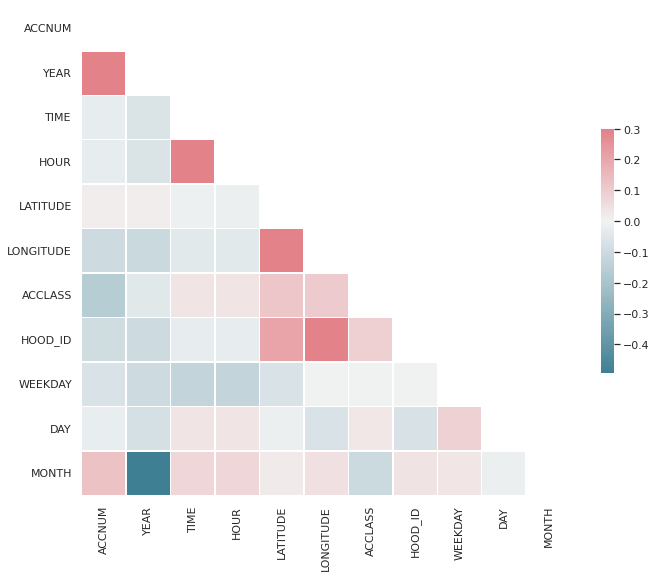

In [ ]:


print(data.isna().sum()/len(data)*100)

#several columns <3% missing values, 
#catagorical feature, not make much sense if impute, so keep the features, just discard these rows with missing values
data.dropna(subset=['ROAD_CLASS', 'DISTRICT','VISIBILITY','RDSFCOND','LOCCOORD','IMPACTYPE','TRAFFCTL','INVTYPE'],inplace=True)

#target class
data['ACCLASS']=data['ACCLASS'].replace({'Non-Fatal':0, 'Fatal':1})
print(data['ACCLASS'].value_counts() )  #dataset is unbalanced

from string import ascii_letters
import seaborn as sns
sns.set(style="white")
# Compute the correlation matrix
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#Resampling- Upsampled

from sklearn.utils import resample
df=data
df_majority = df[df.ACCLASS==0]
df_minority = df[df.ACCLASS==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=14029,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print(df_upsampled.ACCLASS.value_counts())

data=df_upsampled

#Test Train split
#Since the dataset is unbalanced, use straified split
X = data.drop(["ACCLASS"], axis=1)
y= data["ACCLASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5,stratify=y)

X_train.to_csv('x_train_data.csv') 
y_train.to_csv('y_train_data.csv') 
X_test.to_csv('x_test_data.csv') 
y_test.to_csv('y_test_data.csv')

#impute
from sklearn.impute import SimpleImputer    
imputer = SimpleImputer(strategy="constant",fill_value='missing')  
data_tr=imputer.fit_transform(X_train)
data_tr= pd.DataFrame(data_tr, columns=X_train.columns)

print(data_tr.isna().sum()/len(data_tr)*100)

#numerical features
df1=data.drop(['ACCLASS'],axis=1)
num_columns=df1.select_dtypes(include=[np.number]).columns
print(num_columns)
data_num =data_tr[num_columns] 
#standardize 
scaler = StandardScaler() #define the instance
scaled =scaler.fit_transform(data_num)
data_num_scaled= pd.DataFrame(scaled, columns=num_columns)

#categorical features
cat_columns=df1.select_dtypes(exclude=[np.number]).columns
print(cat_columns)
categoricalData =data_tr[cat_columns]

data_cat = pd.get_dummies(categoricalData, columns=cat_columns, drop_first=True)
data_cat

X_train_prepared=pd.concat([data_num_scaled, data_cat], axis=1)
X_train_prepared


#Feature Selection

Index(['ACCNUM', 'YEAR', 'TIME', 'HOUR', 'LATITUDE', 'LONGITUDE', 'HOOD_ID',
       'WEEKDAY', 'DAY', 'MONTH', 'ROAD_CLASS_Major Arterial',
       'ROAD_CLASS_Minor Arterial', 'DISTRICT_North York',
       'DISTRICT_Toronto and East York', 'LOCCOORD_Intersection',
       'LOCCOORD_Mid-Block', 'ACCLOC_missing', 'TRAFFCTL_Traffic Signal',
       'LIGHT_Dark, artificial', 'LIGHT_Daylight', 'RDSFCOND_Wet',
       'IMPACTYPE_Pedestrian Collisions', 'IMPACTYPE_Rear End',
       'IMPACTYPE_Turning Movement', 'PEDESTRIAN_Yes', 'AUTOMOBILE_Yes',
       'TRUCK_Yes', 'TRSN_CITY_VEH_Yes', 'PASSENGER_Yes', 'SPEEDING_Yes',
       'AG_DRIV_Yes'],
      dtype='object')


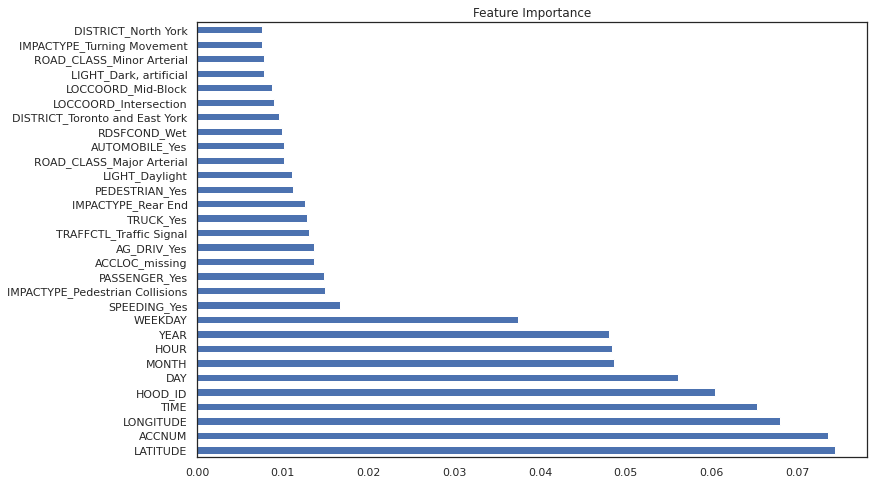

In [ ]:
#method 1: using SelectFromModel and RandomForestClassifier to select features
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train_prepared, y_train)
selected_feat= X_train_prepared.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)

feat_importances = pd.Series(sel.estimator_.feature_importances_, index=X_train_prepared.columns)
#plot the selected features
fig = plt.gcf()
fig.set_size_inches(12, 8)
feat_importances.nlargest(30).plot(kind='barh')
plt.title("Feature Importance")
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Index(['ACCNUM', 'YEAR', 'TIME', 'HOUR', 'LATITUDE', 'LONGITUDE', 'HOOD_ID',
       'WEEKDAY', 'DAY', 'MONTH',
       ...
       'MOTORCYCLE_Yes', 'TRUCK_Yes', 'TRSN_CITY_VEH_Yes', 'EMERG_VEH_Yes',
       'PASSENGER_Yes', 'SPEEDING_Yes', 'AG_DRIV_Yes', 'REDLIGHT_Yes',
       'ALCOHOL_Yes', 'DISABILITY_Yes'],
      dtype='object', length=125)


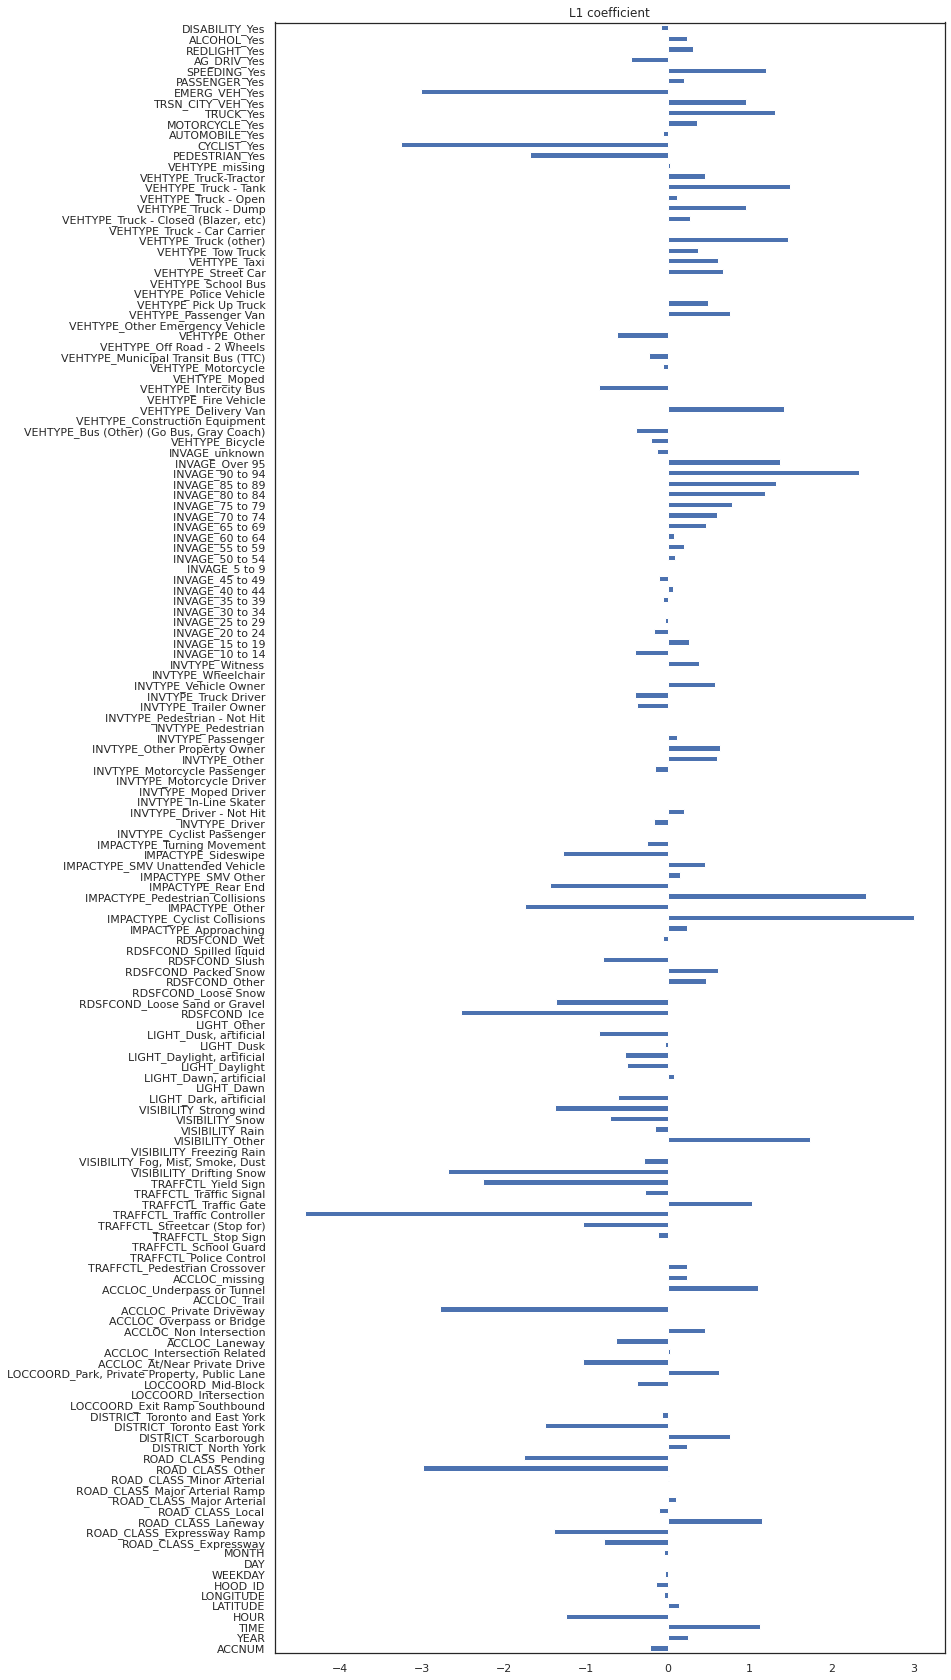

ROAD_CLASS_Major Arterial Ramp     0.0
LOCCOORD_Exit Ramp Southbound      0.0
LOCCOORD_Intersection              0.0
ACCLOC_Overpass or Bridge          0.0
ACCLOC_Trail                       0.0
TRAFFCTL_Police Control            0.0
TRAFFCTL_School Guard              0.0
VISIBILITY_Freezing Rain           0.0
LIGHT_Dawn                         0.0
LIGHT_Other                        0.0
RDSFCOND_Loose Snow                0.0
RDSFCOND_Spilled liquid            0.0
INVTYPE_Cyclist Passenger          0.0
INVTYPE_In-Line Skater             0.0
INVTYPE_Moped Driver               0.0
INVTYPE_Motorcycle Driver          0.0
INVTYPE_Pedestrian                 0.0
INVTYPE_Pedestrian - Not Hit       0.0
INVTYPE_Wheelchair                 0.0
INVAGE_30 to 34                    0.0
INVAGE_5 to 9                      0.0
VEHTYPE_Construction Equipment     0.0
VEHTYPE_Fire Vehicle               0.0
VEHTYPE_Moped                      0.0
VEHTYPE_Off Road - 2 Wheels        0.0
VEHTYPE_Other Emergency V

In [ ]:
#method 2: Logistic regression
from sklearn.linear_model import LogisticRegression
sel = SelectFromModel(LogisticRegression(solver='saga',penalty='l1'))
sel.fit(X_train_prepared, y_train)
selected_feat= X_train_prepared.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)

coefficient= pd.Series(sel.estimator_.coef_[0], index=X_train_prepared.columns)
#plot the selected features
fig = plt.gcf()
fig.set_size_inches(12, 30)
coefficient.plot(kind='barh')
plt.title("L1 coefficient")
plt.show()

abs_coefficient =abs(coefficient)
print(coefficient[coefficient==0])

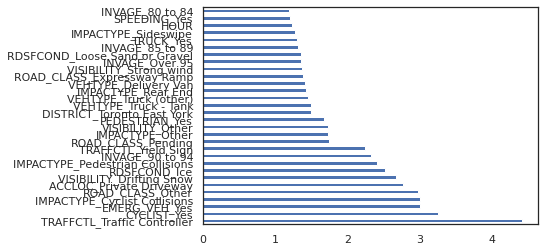

In [ ]:
abs_coefficient.nlargest(30).plot(kind='barh')

In [ ]:

#selected features

#numerical features
num_columns=['ACCNUM', 'YEAR', 'TIME', 'HOUR', 'LATITUDE', 'LONGITUDE', 'WEEKDAY', 'DAY', 'MONTH']
data_num =data_tr[num_columns] 
num_columns=data_num.columns
print(num_columns)

#categorical features

cat_columns=['CYCLIST','AUTOMOBILE','MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH','SPEEDING','REDLIGHT','ALCOHOL','DISABILITY','PASSENGER','AG_DRIV','PEDESTRIAN',
              'ROAD_CLASS', 'DISTRICT',  'TRAFFCTL','VISIBILITY', 'LIGHT', 'RDSFCOND','IMPACTYPE', 'INVAGE']
categoricalData =data_tr[cat_columns]
#categoricalData= data_tr.select_dtypes(exclude=[np.number])
print(categoricalData.columns)
data_cat = pd.get_dummies(categoricalData, columns=cat_columns, drop_first=True)
data_cat

df=pd.concat([data_num, data_cat], axis=1)
df

Index(['ACCNUM', 'YEAR', 'TIME', 'HOUR', 'LATITUDE', 'LONGITUDE', 'WEEKDAY',
       'DAY', 'MONTH'],
      dtype='object')
Index(['CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH',
       'EMERG_VEH', 'SPEEDING', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'PASSENGER', 'AG_DRIV', 'PEDESTRIAN', 'ROAD_CLASS', 'DISTRICT',
       'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVAGE'],
      dtype='object')


,ACCNUM,YEAR,TIME,HOUR,LATITUDE,LONGITUDE,WEEKDAY,DAY,MONTH,CYCLIST_Yes,...,INVAGE_55 to 59,INVAGE_60 to 64,INVAGE_65 to 69,INVAGE_70 to 74,INVAGE_75 to 79,INVAGE_80 to 84,INVAGE_85 to 89,INVAGE_90 to 94,INVAGE_Over 95,INVAGE_unknown
0,9001763544,2019,511,5,43.662169,-79.37263,5,14,9,1,...,0,0,0,0,0,0,0,0,0,0
1,8002016979,2018,1712,17,43.722941,-79.415889,3,1,11,0,...,0,0,0,0,0,0,0,0,0,0
2,1088275,2009,1315,13,43.683145,-79.54049,2,14,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1178905,2010,1329,13,43.691245,-79.50089,5,24,7,0,...,0,0,0,0,0,0,0,0,0,0
4,1340236,2012,936,9,43.693545,-79.48539,1,18,12,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22441,1237144,2011,1930,19,43.748245,-79.54159,5,2,4,0,...,0,0,0,0,0,0,0,0,0,0
22442,8001393342,2018,1238,12,43.800753,-79.236369,0,30,7,0,...,0,0,0,0,0,0,0,0,0,0
22443,9001160017,2019,1909,19,43.761779,-79.215801,5,22,6,0,...,0,0,0,0,0,0,0,0,0,0
22444,5001405584,2015,42,0,43.757712,-79.235263,6,16,8,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
##################

# Pipelines

#################
# build a pipeline for preprocessing the categorical attributes
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='missing')),
        ('one_hot', OneHotEncoder(drop='first')),
    ])
# build a pipeline for preprocessing the numerical attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
#full transformation Column Transformer
num_attribs = num_columns
cat_attribs = cat_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])



In [ ]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_train_prepared.shape

(22446, 96)

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared.shape

(5612, 96)

#Model Training,Tuning and Testing

##Logistic regression

Training Accuracy 0.6888086964269803
Before Tuning:
accuracy 0.6847826086956522
precison 0.6799722318639362
recall 0.6981468282252317
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      2806
           1       0.68      0.70      0.69      2806

    accuracy                           0.68      5612
   macro avg       0.68      0.68      0.68      5612
weighted avg       0.68      0.68      0.68      5612



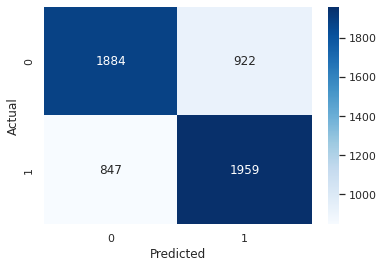

In [ ]:
""" Before Tuning """
#Logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga')
lr.fit(X_train_prepared,y_train)
#predict
y_test_pred=lr.predict(X_test_prepared)
print("Training Accuracy",lr.score(X_train_prepared, y_train))
print("Before Tuning:")

print("accuracy", accuracy_score(y_test, y_test_pred))
print("precison",precision_score(y_test, y_test_pred))
print("recall",recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


confusion_matrix_plot = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_plot, annot=True, cmap="Blues", fmt='g')
plt.show()


In [ ]:
"""After Tuning"""

from sklearn.model_selection import GridSearchCV
#grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],'solver':['saga','liblinear']}
grid = {'penalty': ['l1', 'l2'], 
               'C':[0.01,0.1, 1,10,100,1000],
               'solver':['saga'],
               'max_iter':[1000]
               }
grid_search = GridSearchCV(lr, param_grid =grid,scoring ='accuracy',cv=3,return_train_score=True, verbose = 3)
grid_search.fit(X_train_prepared, y_train)

#Best parameters
print('Best parameters',grid_search.best_params_)
print('Best estimator',grid_search.best_estimator_)
cvres = grid_search.cv_results_
best_logistic_model = grid_search.best_estimator_
y_test_pred=best_logistic_model.predict(X_test_prepared)


from sklearn.metrics import accuracy_score
print("After Tuning:")
print("Accuracy", accuracy_score(y_test, y_test_pred))
print("Precision", precision_score(y_test, y_test_pred))
print("Recall", recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END C=0.01, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.632, test=0.640) total time=   0.8s
[CV 2/3] END C=0.01, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.641, test=0.639) total time=   0.7s
[CV 3/3] END C=0.01, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.641, test=0.631) total time=   0.7s
[CV 1/3] END C=0.01, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.666, test=0.668) total time=   0.1s
[CV 2/3] END C=0.01, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.670, test=0.667) total time=   0.1s
[CV 3/3] END C=0.01, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.672, test=0.663) total time=   0.1s
[CV 1/3] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.674, test=0.680) total time=   0.3s
[CV 2/3] END C=0.1, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.684, test=0.680) total time=   0.2s
[CV 3/3] END C=0.1, max_iter=1000, pe

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3] END C=100, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.682, test=0.685) total time=  14.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3] END C=100, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.691, test=0.685) total time=  26.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3] END C=100, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.688, test=0.683) total time=  25.2s
[CV 1/3] END C=100, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.682, test=0.685) total time=   8.1s
[CV 2/3] END C=100, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.691, test=0.685) total time=   4.8s
[CV 3/3] END C=100, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.689, test=0.683) total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3] END C=1000, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.682, test=0.685) total time=  13.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3] END C=1000, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.691, test=0.685) total time=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3] END C=1000, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.688, test=0.683) total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/3] END C=1000, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.682, test=0.685) total time=   6.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/3] END C=1000, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.691, test=0.685) total time=   6.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/3] END C=1000, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.688, test=0.683) total time=   7.3s
Best parameters {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best estimator LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')
After Tuning:
Accuracy 0.6856735566642908
Precision 0.6802768166089965
Recall 0.7006414825374199
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      2806
           1       0.68      0.70      0.69      2806

    accuracy                           0.69      5612
   macro avg       0.69      0.69      0.69      5612
weighted avg       0.69      0.69      0.69      5612



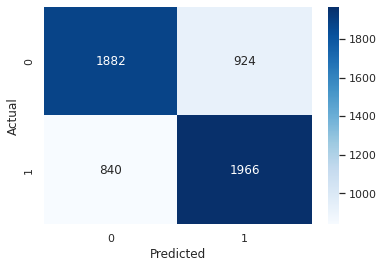

In [ ]:
confusion_matrix_plot = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_plot, annot=True, cmap="Blues", fmt='g')
plt.show()


In [ ]:
lr_fullpipe_feng= Pipeline([
        ('preprocess',full_pipeline),
        ('lr', best_logistic_model)])

import joblib 
# Save the model using the joblib (dump)
joblib.dump(lr_fullpipe_feng,"lr_fullpipe_feng.pkl")

['lr_fullpipe_feng.pkl']

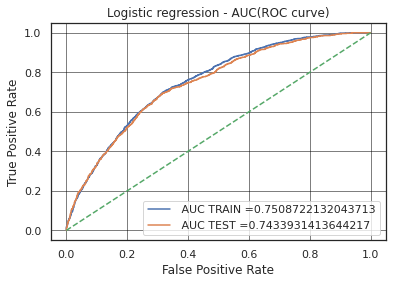

In [ ]:
#define metrics
y_lg_train_pred_proba = best_logistic_model.predict_proba(X_train_prepared)[::,1]
y_lg_test_pred_proba = best_logistic_model.predict_proba(X_test_prepared)[::,1]

train_fpr_lr, train_tpr_lr, tr_thresholds_lr = roc_curve(y_train, y_lg_train_pred_proba)
test_fpr_lr, test_tpr_lr, te_thresholds_lr = roc_curve(y_test, y_lg_test_pred_proba)

plt.grid()

plt.plot(train_fpr_lr, train_tpr_lr, label=" AUC TRAIN ="+str(auc(train_fpr_lr, train_tpr_lr)))
plt.plot(test_fpr_lr, test_tpr_lr, label=" AUC TEST ="+str(auc(test_fpr_lr, test_tpr_lr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic regression - AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

##SVM

In [ ]:
"""
Before Tuning
"""

#SVM
from sklearn.svm import SVC
clf=SVC()
clf.fit(X_train_prepared, y_train)
#accuracy on training dataset
print(clf.score(X_train_prepared,y_train))


#test
#predict
y_test_pred=clf.predict(X_test_prepared)

print("Before Tuning:")
print("accuracy", accuracy_score(y_test, y_test_pred))
print("precison",precision_score(y_test, y_test_pred))
print("recall",recall_score(y_test, y_test_pred))
print("f1 score", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


0.925242804954112
Before Tuning:
accuracy 0.9018175338560228
precison 0.8742117490872884
recall 0.9387027797576621
f1 score 0.9053101907544251
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      2806
           1       0.87      0.94      0.91      2806

    accuracy                           0.90      5612
   macro avg       0.90      0.90      0.90      5612
weighted avg       0.90      0.90      0.90      5612



In [ ]:

""" Tuning: Random Search"""
#SVM
from sklearn.svm import SVC
clf_svm=SVC()

#Random search
param_svm = [
    {'kernel': ['poly','rbf'], 
     'C': [0.01,0.1, 1],
     'gamma': [0.01, 0.05, 0.1],
     'degree':[2,3]}

  ]

random_search_svm = RandomizedSearchCV(estimator=clf_svm, param_distributions=param_svm, cv=3, scoring='accuracy', refit = True, verbose = 3)
random_search_svm.fit(X_train_prepared, y_train)
#Best parameters
print(random_search_svm.best_params_)
print(random_search_svm.best_estimator_)

random_search_svm.cv_results_

best_model= random_search_svm.best_estimator_

#predict using the best model
y_test_pred = best_model.predict(X_test_prepared)

from sklearn.metrics import accuracy_score
print("After Tuning:")
print("Accuracy", accuracy_score(y_test, y_test_pred))
print("Precision", precision_score(y_test, y_test_pred))
print("Recall", recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=0.01, degree=3, gamma=0.1, kernel=poly;, score=0.722 total time=  31.0s
[CV 2/3] END C=0.01, degree=3, gamma=0.1, kernel=poly;, score=0.726 total time=  31.8s
[CV 3/3] END C=0.01, degree=3, gamma=0.1, kernel=poly;, score=0.728 total time=  32.7s
[CV 1/3] END C=0.1, degree=2, gamma=0.01, kernel=poly;, score=0.619 total time=  34.8s
[CV 2/3] END C=0.1, degree=2, gamma=0.01, kernel=poly;, score=0.620 total time=  36.4s
[CV 3/3] END C=0.1, degree=2, gamma=0.01, kernel=poly;, score=0.617 total time=  35.5s
[CV 1/3] END C=0.1, degree=3, gamma=0.05, kernel=rbf;, score=0.719 total time=  35.6s
[CV 2/3] END C=0.1, degree=3, gamma=0.05, kernel=rbf;, score=0.712 total time=  35.1s
[CV 3/3] END C=0.1, degree=3, gamma=0.05, kernel=rbf;, score=0.704 total time=  36.0s
[CV 1/3] END C=0.01, degree=2, gamma=0.05, kernel=poly;, score=0.622 total time=  34.8s
[CV 2/3] END C=0.01, degree=2, gamma=0.05, kernel=poly;, score=0.625 to

In [ ]:
#Fine Tuning - with Grid Search
#SVM
from sklearn.svm import SVC
clf_svm=SVC()

#Grid search
param_grid_svm = [
    {'kernel': ['poly','rbf'], 
     'C': [0.01,0.1, 1],
     'gamma': [0.01, 0.05, 0.1],
     'degree':[2,3]}

  ]

grid_search_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', refit = True, verbose = 3)
grid_search_svm.fit(X_train_prepared, y_train)
#Best parameters
print(grid_search_svm.best_params_)
print(grid_search_svm.best_estimator_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END C=0.01, degree=2, gamma=0.01, kernel=poly;, score=0.619 total time=  35.4s
[CV 2/3] END C=0.01, degree=2, gamma=0.01, kernel=poly;, score=0.620 total time=  45.1s
[CV 3/3] END C=0.01, degree=2, gamma=0.01, kernel=poly;, score=0.617 total time=  39.0s
[CV 1/3] END C=0.01, degree=2, gamma=0.01, kernel=rbf;, score=0.585 total time=  41.5s
[CV 2/3] END C=0.01, degree=2, gamma=0.01, kernel=rbf;, score=0.592 total time=  39.3s
[CV 3/3] END C=0.01, degree=2, gamma=0.01, kernel=rbf;, score=0.586 total time=  38.0s
[CV 1/3] END C=0.01, degree=2, gamma=0.05, kernel=poly;, score=0.622 total time=  33.7s
[CV 2/3] END C=0.01, degree=2, gamma=0.05, kernel=poly;, score=0.625 total time=  37.7s
[CV 3/3] END C=0.01, degree=2, gamma=0.05, kernel=poly;, score=0.630 total time=  36.0s
[CV 1/3] END C=0.01, degree=2, gamma=0.05, kernel=rbf;, score=0.620 total time=  56.8s
[CV 2/3] END C=0.01, degree=2, gamma=0.05, kernel=rbf;, score=

In [ ]:
best_svc_model= grid_search_svm.best_estimator_

svm_fullpipe_zhang= Pipeline([
        ('preprocess',full_pipeline),
        ('svc', best_svc_model)])


# Save the model using the joblib (dump)
joblib.dump(svm_fullpipe_zhang,"svm_fullpipe_zhang.pkl")


#predict using the best model
y_test_pred = svm_fullpipe_zhang.predict(X_test)

from sklearn.metrics import accuracy_score
print("After Tuning:")
print("Accuracy", accuracy_score(y_test, y_test_pred))
print("Precision", precision_score(y_test, y_test_pred))
print("Recall", recall_score(y_test, y_test_pred))
print("f1 score", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

After Tuning:
Accuracy 0.9542052744119743
Precision 0.9324737020699015
Recall 0.9793300071275838
f1 score 0.9553276551364506
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2806
           1       0.93      0.98      0.96      2806

    accuracy                           0.95      5612
   macro avg       0.96      0.95      0.95      5612
weighted avg       0.96      0.95      0.95      5612



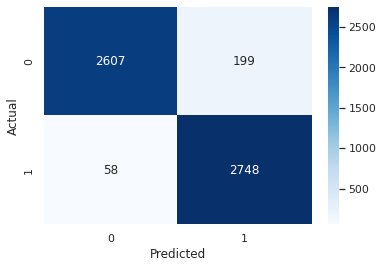

In [ ]:
confusion_matrix_plot = pd.crosstab(y_test['ACCLASS'], y_test_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_plot, annot=True, cmap="Blues", fmt='g')
plt.show()

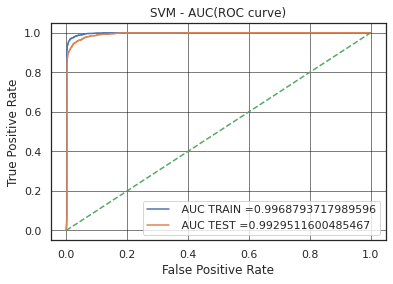

In [ ]:
#ROC curve

y_train_pred = svm_fullpipe_zhang.decision_function(X_train)   
y_test_pred = svm_fullpipe_zhang.decision_function(X_test)

train_fpr_svc, train_tpr_svc, tr_thresholds_svc = roc_curve(y_train, y_train_pred)
test_fpr_svc, test_tpr_svc, te_thresholds_svc = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr_svc, train_tpr_svc, label=" AUC TRAIN ="+str(auc(train_fpr_svc, train_tpr_svc)))
plt.plot(test_fpr_svc, test_tpr_svc, label=" AUC TEST ="+str(auc(test_fpr_svc, test_tpr_svc)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM - AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from time import time


# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=3, criterion = 'entropy', random_state=42)
# Train Decision Tree Classifer
clf = clf.fit(X_train_prepared,y_train)
#Validate using 10 cross fold

clf = DecisionTreeClassifier(min_samples_split=20,criterion = 'entropy',
                                random_state=42)
clf.fit(X_train_prepared, y_train)
scores= cross_val_score(\
   clf, X_train_prepared, y_train, cv=10, scoring='f1_macro')

print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                         end="\n\n" )
#Predict using the test set
y_pred = clf.predict(X_test_prepared)
#Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

"""
Tunning the model
"""
# set of parameters to test
param_grid = {
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
print("-- Grid Parameter Search via 10-fold CV")
dt = DecisionTreeClassifier(criterion = 'entropy')
grid_search = GridSearchCV(dt,
                               param_grid=param_grid,
                               cv=10)
start = time()
grid_search.fit(X_train_prepared, y_train)

print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.cv_results_)))

print('Best Parameters are:',grid_search.best_params_)

#Predict the response for test dataset using the best parameters
best_dt_model = DecisionTreeClassifier(max_depth =5,min_samples_split= 2, criterion = 'entropy', min_samples_leaf= 10, random_state=42 )
tree_fullpipe_Hernandez= Pipeline([
        ('preprocess',full_pipeline),
        ('tree', best_dt_model)])


tree_fullpipe_Hernandez.fit(X_train,y_train)
y_pred = tree_fullpipe_Hernandez.predict(X_test)
#Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Save the model using the joblib (dump)
joblib.dump(tree_fullpipe_Hernandez,"tree_fullpipe_hernandez.pkl")

mean: 0.973 (std: 0.003)

Accuracy: 0.9763007840342124
-- Grid Parameter Search via 10-fold CV

GridSearchCV took 213.34 seconds for 22 candidate parameter settings.
Best Parameters are: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.6589451176051319


['tree_fullpipe_hernandez.pkl']

In [ ]:
print("After Tuning:")
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

After Tuning:
Accuracy 0.6589451176051319
Precision 0.6883445945945946
Recall 0.5808980755523877
f1 score 0.630073444143796
              precision    recall  f1-score   support

           0       0.64      0.74      0.68      2806
           1       0.69      0.58      0.63      2806

    accuracy                           0.66      5612
   macro avg       0.66      0.66      0.66      5612
weighted avg       0.66      0.66      0.66      5612



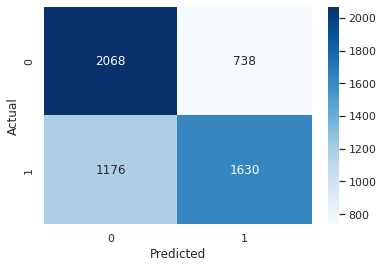

In [ ]:
confusion_matrix_plot = pd.crosstab(y_test['ACCLASS'], y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_plot, annot=True, cmap="Blues", fmt='g')
plt.show()

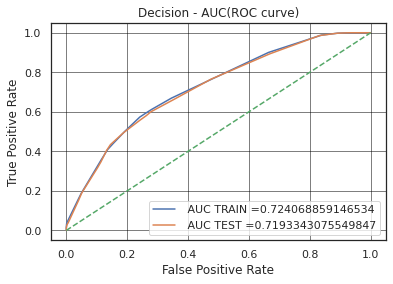

In [ ]:
#ROC curve
y_train_pred = tree_fullpipe_Hernandez.predict_proba(X_train)[::,1]    
y_test_pred = tree_fullpipe_Hernandez.predict_proba(X_test)[::,1]

train_fpr_dt, train_tpr_dt, tr_thresholds_dt = roc_curve(y_train, y_train_pred)
test_fpr_dt, test_tpr_dt, te_thresholds_dt = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr_dt, train_tpr_dt, label=" AUC TRAIN ="+str(auc(train_fpr_dt, train_tpr_dt)))
plt.plot(test_fpr_dt, test_tpr_dt, label=" AUC TEST ="+str(auc(test_fpr_dt, test_tpr_dt)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision - AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# Model Evaluation

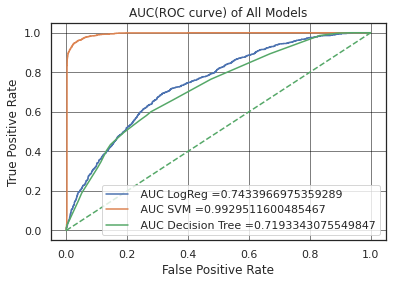

In [ ]:
plt.plot(test_fpr_lr, test_tpr_lr, label=" AUC LogReg ="+str(auc(test_fpr_lr, test_tpr_lr)))
plt.plot(test_fpr_svc, test_tpr_svc, label=" AUC SVM ="+str(auc(test_fpr_svc, test_tpr_svc)))
plt.plot(test_fpr_dt, test_tpr_dt, label=" AUC Decision Tree ="+str(auc(test_fpr_dt, test_tpr_dt)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve) of All Models")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#Make Prediction

In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score

pipeline = joblib.load('svm_fullpipe_zhang.pkl')
#predict using the  model

predict=pipeline.predict(pd.DataFrame({'ACCNUM':953178, 'TIME':2022,'LATITUDE':43.8, 'LONGITUDE':-79.3, 
                                             'WEEKDAY':2,'DAY':14, 'MONTH':2,'YEAR': 2020, 'HOUR':7,'CYCLIST':'No', 'AUTOMOBILE':'Yes',
                                                   'MOTORCYCLE':'No', 'TRUCK':'No',
                                                   'TRSN_CITY_VEH':'No', 'EMERG_VEH':'No',
                                                   'SPEEDING':'Yes', 'REDLIGHT':'Yes',
                                                   'ALCOHOL':'No', 'DISABILITY':'No',
                                                   'PASSENGER':'No', 'AG_DRIV':'Yes',
                                                   'PEDESTRIAN':'Yes', 'ROAD_CLASS':'Major Arterial',
                                                   'DISTRICT':'Scarborough', 'TRAFFCTL':'No Control',
                                                   'VISIBILITY':'Snow', 'LIGHT':'Dark',
                                                   'RDSFCOND':'Packed Snow', 'IMPACTYPE':'Pedestrian Collisions',
                                                   'INVAGE':'20 to 24'},index=[0]))

print("predicted",predict)

predicted [1]
